First submission using a logistic regression classifier.

Approach:
1 - view data
2 - choose columns which seem most viable
3 - visualise data

In [156]:
#read data
import pandas as pd
import numpy as np

df = pd.read_csv('../input/train.csv')
len(df.index)

891

Throw away useless data

In [133]:
# drop unused columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin', 'Fare'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [134]:
# visualize data for sex survived

sex_survived_df = df[['Sex', 'Survived']]
sex_survived_df = sex_survived_df.groupby(['Sex', 'Survived']).size()
sex_survived_df.head()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
dtype: int64

In [135]:
# visualize data for survivors with siblings on board

sib_survived_df = df[['SibSp', 'Survived']]
sib_survived_df = sib_survived_df.groupby(['SibSp', 'Survived']).size()
sib_survived_df.head(n=20)

SibSp  Survived
0      0           398
       1           210
1      0            97
       1           112
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
dtype: int64

In [136]:
# visualize data for survivors with parents on board

parch_survived_df = df[['Parch', 'Survived']]
parch_survived_df = parch_survived_df.groupby(['Parch', 'Survived']).size()
parch_survived_df.head(n=6)

Parch  Survived
0      0           445
       1           233
1      0            53
       1            65
2      0            40
       1            40
dtype: int64

In [137]:
# visualize data for pclass survived

pclass_survived_df = df[['Pclass', 'Survived']]
pclass_survived_df = pclass_survived_df.groupby(['Pclass', 'Survived']).size()
pclass_survived_df.head(n=6)

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
dtype: int64

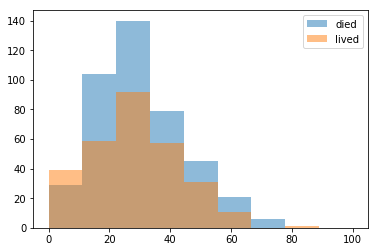

In [138]:
from matplotlib import pyplot

# visualize data for pclass survived

pclass_survived_df = df[['Age', 'Survived']]
pclass_lived_df = df.loc[df['Survived'] == 1]
pclass_died_df = df.loc[df['Survived'] == 0]


lived = pclass_lived_df['Age'].astype(np.float).dropna()
died = pclass_died_df['Age'].astype(np.float).dropna()
bins = np.linspace(0, 100, 10)

pyplot.hist(died, bins, alpha=0.5, label='died')
pyplot.hist(lived, bins, alpha=0.5, label='lived')
pyplot.legend(loc='upper right')
pyplot.show()

From the above, we can draw the conclusion that the best columns to use from the dataset are

 1. Sex
 2. Pclass
 3. Age (Optional)

In [183]:
from sklearn import cross_validation, preprocessing

# prep data
df2 = df[['Age', 'Pclass', 'Sex', 'Survived']]
df2['Sex'] = (df['Sex'] !='male')
df2 = df2.astype(float).dropna()


X = df2.ix[:,['Age', 'Pclass', 'Sex']].as_matrix()
X = preprocessing.scale(X)
y = df2.Survived.astype(int).as_matrix()
labels = np.unique(y)

[X_train, X_test, y_train, y_test] = cross_validation.train_test_split(X, y, test_size = 0.3)

/opt/conda/bin/ipython:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([0, 1])

In [181]:
# create logisitic regression model

from sklearn import linear_model

clf = linear_model.LogisticRegression().fit(X_train, y_train);

print("logistic regression model trained")

logistic regression model trained


In [193]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

y_pred = clf.predict(X_test)

precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

print("precision: " + str(precision))
print("recall: " + str(recall))
print("f_score: " + str(f_score))

precision: [ 0.78832117  0.78205128]
recall: [ 0.864       0.67777778]
f_score: [ 0.82442748  0.72619048]
